In [15]:
import os
from pathlib import Path
from datetime import datetime
from datetime import datetime, timedelta
from io import StringIO

import numpy as np
import pandas as pd
import requests

from dateutil.tz import tzutc, tzlocal
import math

In [16]:
def USGS_Data_Request(site, start_date, end_date, parameter):
    """
    Download USGS instantaneous data from NWIS API.
    Handles errors gracefully, converts to metric units, and adjusts for HST.
    """
    
    param_units = {
        "00045": "in",       # Precipitation
        "00060": "ft3_s",    # Discharge
        "00065": "ft"        # Gage height
    }

    if parameter not in param_units:
        raise ValueError("Unsupported parameter code. Use '00045', '00060', or '00065'.")

    unit_col = param_units[parameter]

    url = (
        f"https://waterservices.usgs.gov/nwis/iv/?format=json"
        f"&sites={site}&startDT={start_date}&endDT={end_date}"
        f"&parameterCd={parameter}&siteStatus=all"
    )

    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from USGS: {e}")
        return pd.DataFrame()

    # Handle case where no timeSeries are returned
    if not data.get('value', {}).get('timeSeries'):
        print(f"No data available for site {site} and parameter {parameter}")
        return pd.DataFrame()

    # Parse valid entries
    rows = []
    for ts in data['value']['timeSeries']:
        for entry in ts['values'][0]['value']:
            val_str = entry.get("value", "")
            try:
                val = float(val_str)
            except ValueError:
                val = None

            rows.append({
                "DateTime": entry["dateTime"],
                unit_col: val
            })

    # Build DataFrame
    df = pd.DataFrame(rows)
    print(df)
    df['DateTime'] = pd.to_datetime(df['DateTime']).dt.tz_localize(None)
    df = df[['DateTime', unit_col]]

    return df

def format_date_string(date_str):
    """
    Convert 'YYYY-MM-DD' into 'YYYY-MM-DDTHH:MM' format (default midnight).
    """
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    return dt.strftime("%Y-%m-%dT%H:%M")

In [14]:
site = '212855157504501'

start_date = format_date_string("2007-08-09")
end_date = format_date_string("2025-08-28")
#datetime.utcnow().strftime('%Y-%m-%dT%H:%M')

df_212855157504501_RF = USGS_Data_Request(site, start_date, end_date, parameter)




                             DateTime   in
0       2007-08-09T00:00:00.000-10:00  0.0
1       2007-08-09T00:15:00.000-10:00  0.0
2       2007-08-09T00:30:00.000-10:00  0.0
3       2007-08-09T00:45:00.000-10:00  0.0
4       2007-08-09T01:00:00.000-10:00  0.0
...                               ...  ...
627715  2025-08-27T23:00:00.000-10:00  0.0
627716  2025-08-27T23:15:00.000-10:00  0.0
627717  2025-08-27T23:30:00.000-10:00  0.0
627718  2025-08-27T23:45:00.000-10:00  0.0
627719  2025-08-28T00:00:00.000-10:00  0.0

[627720 rows x 2 columns]


In [17]:
#Mountain Gauge save it for return period data
#Waiahole Rain Gage
site = '213215157552800'
parameter = "00045"

# Set start and end dates in UTC with time included
start_date = format_date_string("2009-12-16")
end_date = format_date_string("2025-08-28")
#datetime.utcnow().strftime('%Y-%m-%dT%H:%M')

df_213215157552800_RF = USGS_Data_Request(site, start_date, end_date, parameter)

                             DateTime   in
0       2009-12-16T00:15:00.000-10:00  0.0
1       2009-12-16T00:30:00.000-10:00  0.0
2       2009-12-16T01:00:00.000-10:00  0.0
3       2009-12-16T01:15:00.000-10:00  0.0
4       2009-12-16T01:30:00.000-10:00  0.0
...                               ...  ...
541746  2025-08-27T23:00:00.000-10:00  0.0
541747  2025-08-27T23:15:00.000-10:00  0.0
541748  2025-08-27T23:30:00.000-10:00  0.0
541749  2025-08-27T23:45:00.000-10:00  0.0
541750  2025-08-28T00:00:00.000-10:00  0.0

[541751 rows x 2 columns]


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearson3

def lp3_return_levels_rolling(df, date_col="DateTime", rain_col="in",
                              return_periods=(1, 2, 5, 10, 25, 50, 100),
                              window="60min"):
    """
    Compute LP3 return levels using rolling window maxima.
    """
    s = (df.copy()
           .assign(**{date_col: pd.to_datetime(df[date_col])})
           .set_index(date_col)[rain_col]
           .astype(float))

    # --- 1. Build rolling totals (e.g., 60min sliding window) ---
    roll_totals = s.rolling(window=window, min_periods=1).sum()

    # --- 2. Annual maxima of those rolling totals ---
    ams = roll_totals.resample("Y").max().dropna()
    ams = ams[ams > 0]  # drop zero years

    # --- 3. Fit LP3 on log10 values ---
    log_ams = np.log10(ams.values)
    skew, loc, scale = pearson3.fit(log_ams)

    # --- 4. Compute return levels ---
    Ts = np.asarray(return_periods, dtype=float)
    p = 1 - 1/Ts
    qlog = pearson3.ppf(p, skew, loc=loc, scale=scale)
    depths = 10**qlog

    out = pd.DataFrame({"ReturnPeriod_yr": Ts, "Rain_in": depths})
    out.attrs["lp3_params"] = {"skew": skew, "loc": loc, "scale": scale,
                               "n_years": len(ams)}
    return out, ams


In [33]:
# Ensure your columns are correctly typed
#df_213215157552800_RF["DateTime"] = pd.to_datetime(df_213215157552800_RF["DateTime"])
#df_213215157552800_RF["in"] = pd.to_numeric(df_213215157552800_RF["in"], errors="coerce")

# Get 1- and 5-year return levels (you can add others if you want)
rl = gev_return_levels_1h(df_213215157552800_RF, return_periods=(1, 5))
print(rl)
# -> DataFrame with rows for 1 yr and 5 yr, column 'Rain_in'
#    plus GEV parameters in rl.attrs["gev_params"]

rl_lp3 = lp3_return_levels_1h(df_213215157552800_RF, return_periods=(1, 2, 5, 10, 25, 50, 100))
print(rl_lp3)

   ReturnPeriod_yr   Rain_in
0                1      -inf
1                5  3.232548
   ReturnPeriod_yr   Rain_in
0                1  0.000000
1                2  2.129981
2                5  3.123545
3               10  3.889679
4               25  4.988894
5               50  5.908309
6              100  6.918455


C:\Users\bgorb\AppData\Local\Temp\ipykernel_32836\648404492.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  one_h = s.resample("1H").sum().dropna()
C:\Users\bgorb\AppData\Local\Temp\ipykernel_32836\648404492.py:27: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ams = one_h.resample("Y").max().dropna()
C:\Users\bgorb\AppData\Local\Temp\ipykernel_32836\648404492.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  one_h = s.resample("1H").sum(min_count=1)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_32836\648404492.py:65: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ams = one_h.resample("Y").max()


In [34]:
def plot_lp3_curve(df, date_col="DateTime", rain_col="in"):
    rl, ams = lp3_return_levels_rolling(df, date_col, rain_col)

    # Smooth curve
    Ts_smooth = np.logspace(0.1, 2, 200)
    params = rl.attrs["lp3_params"]
    depths_smooth = 10**pearson3.ppf(1 - 1/Ts_smooth,
                                     params["skew"], loc=params["loc"], scale=params["scale"])

    # Empirical plotting positions
    n = len(ams)
    ranks = np.arange(1, n+1)[::-1]
    T_emp = (n+1)/ranks

    plt.figure(figsize=(7,5))
    plt.plot(Ts_smooth, depths_smooth, label="LP3 fit", color="green")
    plt.scatter(T_emp, ams.values, color="black", zorder=5, label="AMS points")
    plt.xscale("log")
    plt.xlabel("Return period (years)")
    plt.ylabel("1-hour rolling max rainfall (in)")
    plt.title("Log-Pearson III Return Levels (1h rolling maxima)")
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

    return rl


C:\Users\bgorb\AppData\Local\Temp\ipykernel_32836\2011658109.py:21: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ams = roll_totals.resample("Y").max().dropna()


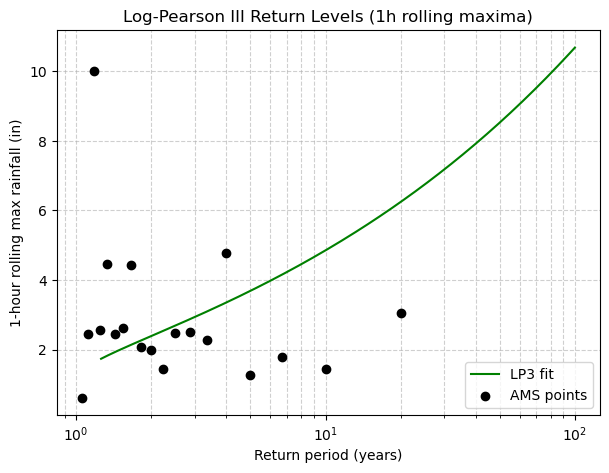

   ReturnPeriod_yr    Rain_in
0              1.0   0.000000
1              2.0   2.389691
2              5.0   3.689892
3             10.0   4.853095
4             25.0   6.748038
5             50.0   8.528068
6            100.0  10.680917


In [35]:
rl_lp3 = plot_lp3_curve(df_all, date_col="DateTime", rain_col="in")
print(rl_lp3)


C:\Users\bgorb\AppData\Local\Temp\ipykernel_32836\1380425630.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H").sum(min_count=1)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_32836\1380425630.py:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y").max()


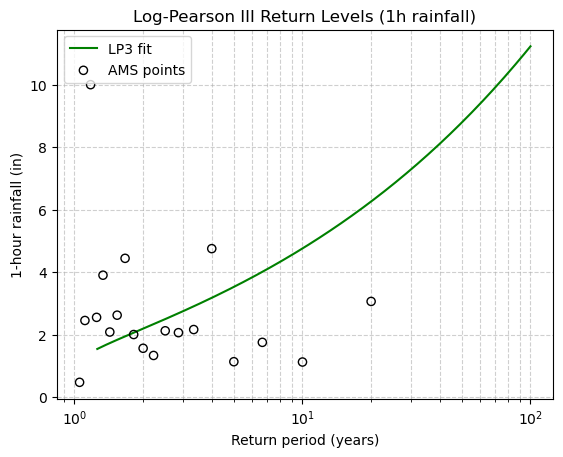

In [31]:
import numpy as np
import pandas as pd
from scipy.stats import pearson3
import matplotlib.pyplot as plt

# --- your existing LP3 curve (unchanged) ---
Ts = np.logspace(0.1, 2, 200)  # 1.26 to 100 yr
ams = (df_all
       .set_index(pd.to_datetime(df_all["DateTime"]))
       ["in"]
       .astype(float)
       .resample("1H").sum(min_count=1)
       .resample("Y").max()
       .dropna())
ams = ams[ams > 0]  # drop zero years so log is defined

skew, loc, scale = pearson3.fit(np.log10(ams.values))
depths = 10**pearson3.ppf(1 - 1/Ts, skew, loc=loc, scale=scale)

plt.figure()
plt.plot(Ts, depths, label="LP3 fit", color="green")
plt.xscale("log")
plt.xlabel("Return period (years)")
plt.ylabel("1-hour rainfall (in)")
plt.title("Log-Pearson III Return Levels (1h rainfall)")
plt.grid(True, which="both", ls="--", alpha=0.6)

# --- add the AMS points (Weibull plotting positions) ---
n = len(ams)
if n > 0:
    # Rank from largest to smallest so the biggest max gets the largest T
    ranks = np.arange(1, n+1)[::-1]
    T_emp = (n + 1) / ranks              # Weibull plotting position
    y_emp = ams.values

    # Use scatter (or marker-only line) with high zorder so it sits on top
    plt.scatter(T_emp, y_emp, s=35, edgecolors="k", facecolors="none",
                zorder=5, label="AMS points")
    # (alternative) plt.plot(T_emp, y_emp, ls="", marker="o", ms=5, mfc="none", mec="k", zorder=5, label="AMS points")

plt.legend()
plt.show()


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

def gev_with_points_and_table(df, date_col="DateTime", rain_col="in",
                              window="180min", return_periods=(1,2,5,10,25,50,100)):
    """
    Fit GEV to annual max rolling rainfall (e.g. 3h) and:
      - plot smooth curve + AMS points
      - print return period rainfall values
    """
    # 1. Prep data
    s = (df.copy()
           .assign(**{date_col: pd.to_datetime(df[date_col])})
           .set_index(date_col)[rain_col]
           .astype(float))

    # 2. Rolling totals
    roll_totals = s.rolling(window=window, min_periods=1).sum()

    # 3. Annual maxima
    ams = roll_totals.resample("Y").max().dropna()
    ams = ams[ams > 0]

    # 4. Fit GEV
    c, loc, scale = genextreme.fit(ams.values)

    # 5. Smooth curve
    Ts_smooth = np.logspace(0.1, 2, 200)
    depths = genextreme.ppf(1 - 1/Ts_smooth, c, loc=loc, scale=scale)

    # 6. Empirical plotting positions
    n = len(ams)
    ranks = np.arange(1, n+1)[::-1]
    T_emp = (n+1)/ranks

    # 7. Plot
    plt.figure(figsize=(7,5))
    plt.plot(Ts_smooth, depths, label=f"GEV fit ({window})", color="blue")
    plt.scatter(T_emp, ams.values, color="black", zorder=5, label="AMS points")
    plt.xscale("log")
    plt.xlabel("Return period (years, log scale)")
    plt.ylabel(f"{window} rainfall (in)")
    plt.title(f"GEV Return Levels ({window} rolling maxima)")
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

    # 8. Table of requested return periods
    rp_depths = []
    for T in return_periods:
        q = genextreme.ppf(1 - 1/T, c, loc=loc, scale=scale)
        rp_depths.append((T, q))

    results = pd.DataFrame(rp_depths, columns=["ReturnPeriod_yr","Rain_in"])
    print("\nEstimated Return Period Rainfall ({} rolling):".format(window))
    print(results.to_string(index=False))

    return {"ams": ams, "gev_params": (c, loc, scale), "results": results}


C:\Users\bgorb\AppData\Local\Temp\ipykernel_32836\2751576257.py:21: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ams = roll_totals.resample("Y").max().dropna()


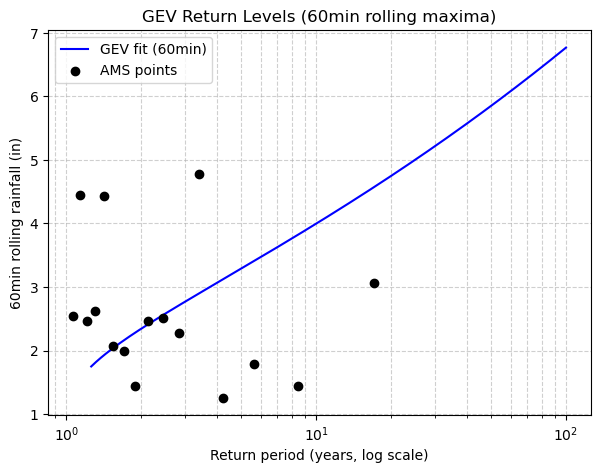

GEV params: (-0.1396697870645641, 2.0733150789969628, 0.7274828761848509)


In [51]:
out = gev_with_points_and_table(df_all, date_col="DateTime", rain_col="in", window="180min")

